In [25]:
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
import mne

data_dir = "/Users/martin.iniguez/Desktop/master-thesis/opm-thesis/data/digits_epochs/"
file = data_dir + "/freq_bands/all_data_all_epochs_decimated.pkl"
all_epochs = pickle.load(open(file, "rb")).pick(picks="meg",exclude="bads")


In [26]:
labels = np.unique(all_epochs.events[:, -1])
fmin = 8
fmax = 60
freqs = np.arange(fmin, fmax + 1, 3)
n_cycles = freqs / 2  # different number of cycle per frequency

if os.path.exists(data_dir + "all_epochs_tfr.pkl"):
    with open(data_dir + "all_epochs_tfr.pkl", "rb") as f:
        power = pickle.load(f)
else:

    power = {}
    for idx, label in enumerate(labels):
        valid_epochs_mask = np.isin(all_epochs.events[:, -1], label)
        label_epochs = all_epochs[valid_epochs_mask]

        power[str(idx + 1)] = mne.time_frequency.tfr_morlet(
            label_epochs,
            freqs=freqs,
            n_cycles=n_cycles,
            n_jobs=1,
            return_itc=False,
            decim=3,
        )
    with open(data_dir + "all_epochs_tfr.pkl", "wb") as f:
        pickle.dump(power, f)

if os.path.exists(data_dir + "individual_epoch_tfr.pkl"):
    with open(data_dir + "individual_epoch_tfr.pkl", "rb") as f:
        power_per_epoch = pickle.load(f)

else:
    power_per_epoch = mne.time_frequency.tfr_morlet(
            all_epochs,
            freqs=freqs,
            n_cycles=n_cycles,
            n_jobs=5,
            return_itc=False,
            decim=3,
            average=False,
        )
    with open(data_dir + "individual_epoch_tfr.pkl", "wb") as f:
        pickle.dump(power_per_epoch, f)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Applying baseline correction (mode: logratio)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Applying baseline correction (mode: logratio)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Applying baseline correction (mode: logratio)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Applying baseline correction (mode: logratio)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Applying baseline correction (mode: logratio)


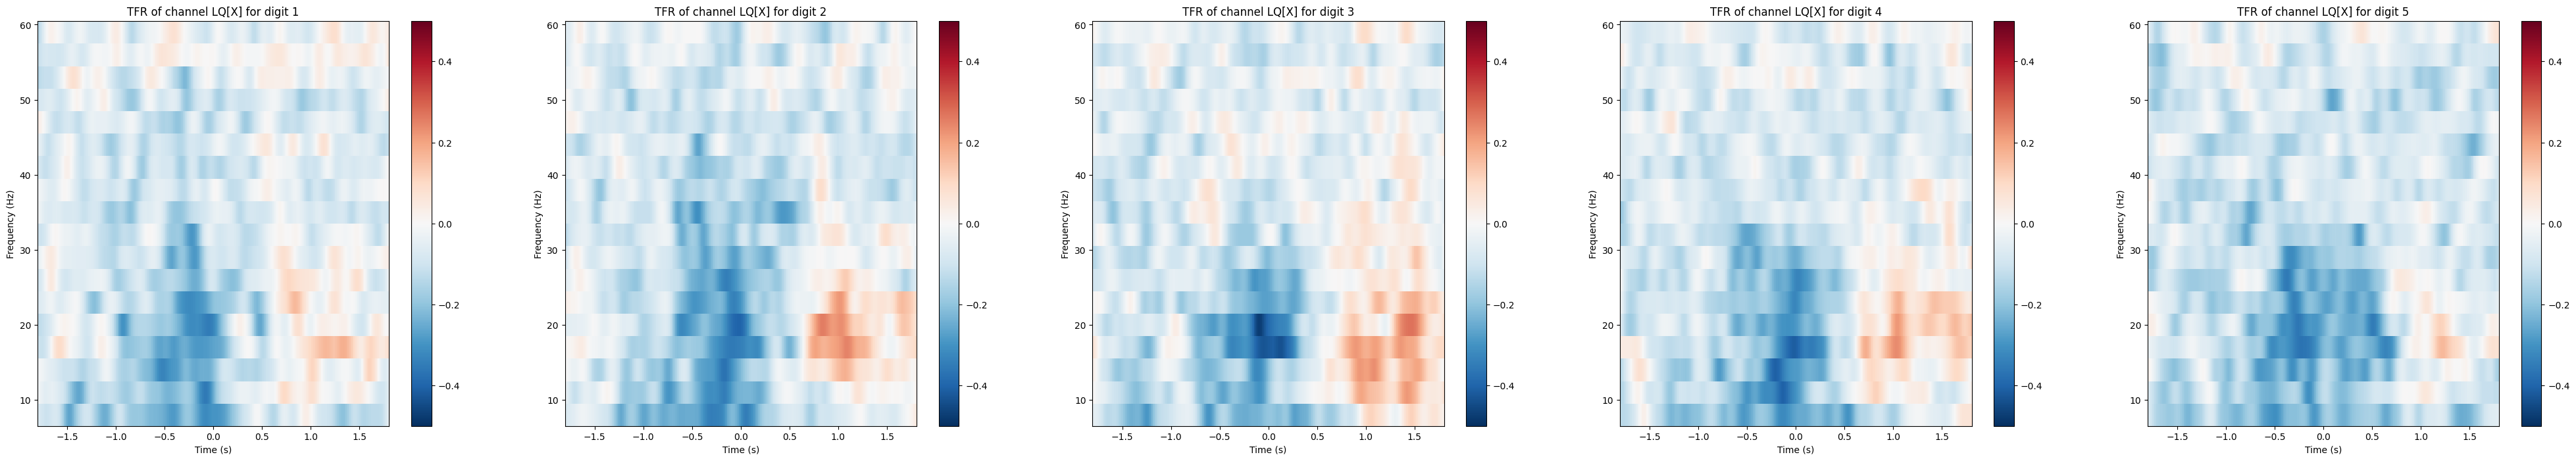

In [27]:
center_channel = "LQ[X]"
idx_channel = all_epochs.ch_names.index(center_channel)
epochs = all_epochs.pick(center_channel).copy()

conditions = [1, 2, 3, 4, 5]

# Create a figure with subplots
fig, axes = plt.subplots(
    1, len(conditions), figsize=(50, 8)
)  # Adjust figsize as needed

for i, condition in enumerate(conditions):
    # Select the subplot
    ax = axes[i]

    # Plot the 5 different digits in a subplot horziontally
    power[str(i + 1)].plot(
        [idx_channel],
        baseline=(-2, -0.57),
        mode="logratio",
        tmin=-1.8,
        tmax=1.8,
        axes=ax,
        show=False,
        vmin=-0.5,
        vmax=0.5,
    )
    ax.set_title("TFR of channel " + center_channel + " for digit " + str(i + 1))

## Creating a classifier

In [28]:
import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

from opm_thesis.classifiers.classifier import TimeFreqCNN, MyDataset

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

labels_to_use = [32, 128]
labels = all_epochs.events[:, -1]

valid_epochs_mask = np.isin(labels, labels_to_use)
data = power_per_epoch.data[valid_epochs_mask]
labels = labels[valid_epochs_mask]

label_mapping = {label: idx for idx, label in enumerate(labels_to_use)}
# Map the labels to 0 and 1
final_targets = np.array(
    [label_mapping[label] for label in labels if label in label_mapping]
)

# Split the data into training and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(
    data, final_targets, test_size=0.2, random_state=42
)

# Create PyTorch datasets and loaders
train_dataset = MyDataset(train_data, train_labels)
test_dataset = MyDataset(test_data, test_labels)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

# Train the classifier and evaluate it
classifier = TimeFreqCNN(
    len(labels_to_use), data.shape[1], data.shape[2], data.shape[3], device
)
classifier.train_model(train_loader, num_epochs=20, learning_rate=1e-3)
classifier.evaluate(test_loader)*100

Epoch 1, Loss: 1.3868
Epoch 2, Loss: 1.3865
Epoch 3, Loss: 1.3861
Epoch 4, Loss: 1.3866
Epoch 5, Loss: 1.3867
Epoch 6, Loss: 1.3858
Epoch 7, Loss: 1.3870
Epoch 8, Loss: 1.3862
Epoch 9, Loss: 1.3862
Epoch 10, Loss: 1.3873
Epoch 11, Loss: 1.3865
Epoch 12, Loss: 1.3863
Epoch 13, Loss: 1.3860
Epoch 14, Loss: 1.3863
Epoch 15, Loss: 1.3868
Epoch 16, Loss: 1.3862
Epoch 17, Loss: 1.3862
Epoch 18, Loss: 1.3866
Epoch 19, Loss: 1.3865
Epoch 20, Loss: 1.3866


45.16129032258064

In [29]:
power_per_epoch_labelled = {}
labels = np.unique(all_epochs.events[:, -1])

for idx, label in enumerate(labels):
    valid_epochs_mask = np.isin(all_epochs.events[:, -1], label)
    power_per_epoch_labelled[idx] = power_per_epoch[valid_epochs_mask]

In [30]:
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

t_test_results = {}

# Perform t-tests between each pair of conditions
for condition1 in range(1, 6):
    for condition2 in range(condition1 + 1, 6):
        # Compute the t-test on the two independent samples
        t_stat, p_value = ttest_ind(
            power[str(condition1)].data, power[str(condition2)].data, axis=0
        )

        # Apply multiple comparisons correction using FDR
        p_value_reshaped = p_value.flatten()
        reject, p_value_corrected, _, _ = multipletests(
            p_value_reshaped, method="fdr_bh"
        )
        p_value_corrected_reshaped = p_value_corrected.reshape(p_value.shape)

        # Store the corrected p-values and t-statistics
        t_test_results[(condition1, condition2)] = {
            "t_stat": t_stat,
            "p_value_corrected": p_value_corrected_reshaped,
        }

# Choose a significance level
alpha = 0.05

# Create a dictionary to store whether each test is significant
significant_results = {}

# Check for significance and store the results
for key, result in t_test_results.items():
    significant_mask = result["p_value_corrected"] < alpha
    significant_results[key] = significant_mask

for condition_pair, mask in significant_results.items():
  num_significant_points = np.sum(mask)
  print(f"Condition pair {condition_pair} has {num_significant_points} significant points after correction.")

Condition pair (1, 2) has 0 significant points after correction.
Condition pair (1, 3) has 0 significant points after correction.
Condition pair (1, 4) has 0 significant points after correction.
Condition pair (1, 5) has 0 significant points after correction.
Condition pair (2, 3) has 0 significant points after correction.
Condition pair (2, 4) has 0 significant points after correction.
Condition pair (2, 5) has 0 significant points after correction.
Condition pair (3, 4) has 0 significant points after correction.
Condition pair (3, 5) has 387 significant points after correction.
Condition pair (4, 5) has 0 significant points after correction.


['FR[Z]',
 'FR[Y]',
 'FR[X]',
 'FS[Z]',
 'FS[Y]',
 'FS[X]',
 'FT[Z]',
 'FT[Y]',
 'FT[X]',
 'FU[Z]',
 'FU[Y]',
 'FU[X]',
 'FV[Z]',
 'FV[Y]',
 'FV[X]',
 'FW[Z]',
 'FW[Y]',
 'FW[X]',
 'FX[Z]',
 'FX[Y]',
 'FX[X]',
 'FY[Z]',
 'FY[Y]',
 'FY[X]',
 'FZ[Y]',
 'G0[Z]',
 'G0[Y]',
 'G0[X]',
 'G2[Z]',
 'G2[Y]',
 'G2[X]',
 'HE[Z]',
 'HE[Y]',
 'HE[X]',
 'HF[Z]',
 'HF[Y]',
 'HF[X]',
 'HG[Z]',
 'HG[Y]',
 'HG[X]',
 'HH[Z]',
 'HH[Y]',
 'HH[X]',
 'HI[Z]',
 'HI[Y]',
 'HI[X]',
 'HJ[Z]',
 'HJ[Y]',
 'HJ[X]',
 'HK[Z]',
 'HK[Y]',
 'HK[X]',
 'HL[Z]',
 'HL[Y]',
 'HL[X]',
 'HN[Z]',
 'HN[Y]',
 'HN[X]',
 'HO[Z]',
 'HO[Y]',
 'HO[X]',
 'HQ[Z]',
 'HQ[Y]',
 'HQ[X]',
 'I0[Z]',
 'I0[Y]',
 'I0[X]',
 'I1[Z]',
 'I1[Y]',
 'I1[X]',
 'I2[Z]',
 'I2[Y]',
 'I2[X]',
 'I3[Z]',
 'I3[Y]',
 'I3[X]',
 'I4[Z]',
 'I4[Y]',
 'I4[X]',
 'I5[Z]',
 'I5[Y]',
 'I5[X]',
 'I6[Z]',
 'I6[Y]',
 'I6[X]',
 'I7[Z]',
 'I7[Y]',
 'I7[X]',
 'K7[Z]',
 'K7[Y]',
 'K7[X]',
 'K8[Z]',
 'K8[Y]',
 'K8[X]',
 'K9[Z]',
 'K9[Y]',
 'KB[Z]',
 'KB[Y]',
 'KB[X]',
 'KC[Z]',


## Plot the significant points

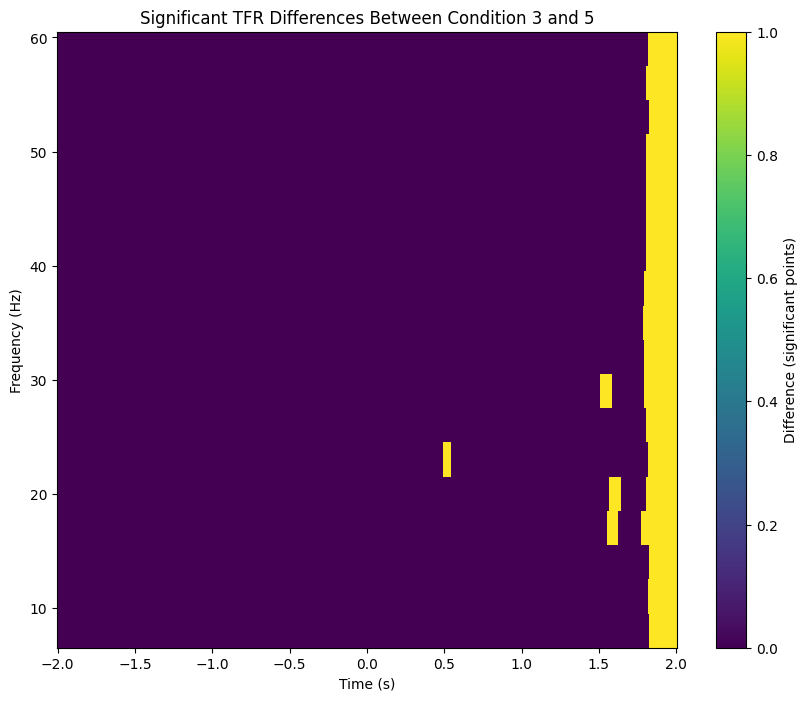

In [58]:
plt.figure(figsize=(10, 8))
index_center_channel = power[str(3)].ch_names.index(center_channel)

significant_mask = significant_results[(3, 5)]
difference_tfr = (
    power[str(3)].data[index_center_channel] - power[str(5)].data[index_center_channel]
)
masked_difference_tfr = np.ma.array(difference_tfr, mask=~significant_mask)
time = np.linspace(-2, 2, difference_tfr.shape[1])
frequency = np.arange(difference_tfr.shape[0])
T, F = np.meshgrid(time, freqs)
plt.pcolormesh(T, F, significant_mask, shading="auto")
plt.colorbar(label="Difference (significant points)")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.title("Significant TFR Differences Between Condition 3 and 5")
plt.show()